In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, and_
from flask import Flask, jsonify

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [30]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [34]:
for table in ['measurement', 'station']:
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'], c["type"])
    print('-' * 8)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------


# Exploratory Climate Analysis

In [77]:
type(most_recent_date)

sqlalchemy.util._collections.result

In [98]:
most_recent_date

'2017-08-23'

Text(0,0.5,'Rainfall in Inches')

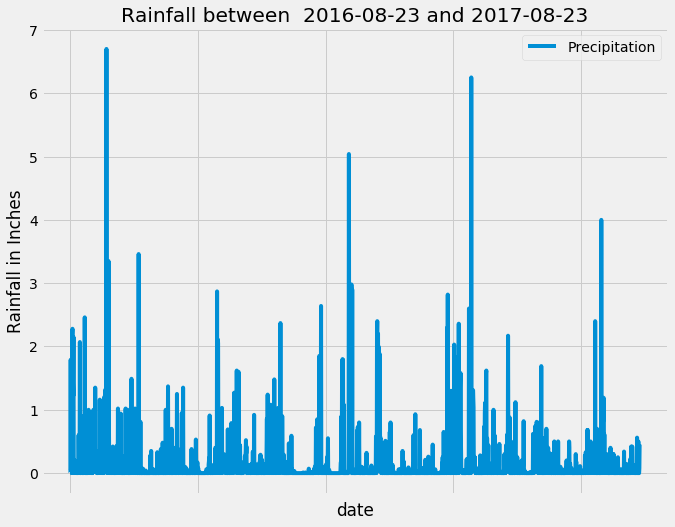

In [141]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
most_recent_date= (dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')).strftime("%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
most_recent_date
one_year_date = ('2016-08-23')

# Perform a query to retrieve the data and precipitation scores
one_year_rain = session.query(Measurement.date, Measurement.prcp).filter(
                                    Measurement.date.between(one_year_date,most_recent_date)).all();

# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_rain = pd.DataFrame(one_year_rain).set_index('date')
one_year_rain = one_year_rain.rename(columns={'prcp': 'Precipitation'})
one_year_rain = one_year_rain.fillna(0)

# Sort the dataframe by date
one_year_rain.sort_values(by='date',inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = one_year_rain.plot(kind='line', figsize=(10,8),
                               title = "Rainfall between  2016-08-23 and 2017-08-23")
ax.set_ylabel("Rainfall in Inches")

In [142]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_rain.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [151]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().all()
station_count = len(stations)


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [171]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station)
station_counts=station_counts.order_by(func.count(Measurement.prcp).desc()).all()
print(f"The Most active stations are {[station_counts[n][0] for n in range(0,3)]}")
station_counts

The Most active stations are ['USC00519281', 'USC00513117', 'USC00519397']


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [200]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?

lowest = session.query(Measurement.station,func.min(Measurement.tobs)).\
filter(Measurement.date.between(one_year_date,most_recent_date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()

highest = session.query(Measurement.station,func.max(Measurement.tobs)).\
filter(Measurement.date.between(one_year_date,most_recent_date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()

average = session.query(Measurement.station, func.avg(Measurement.tobs)).\
filter(Measurement.date.between(one_year_date,most_recent_date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.prcp).desc()).limit(3).all()
average = [(average[n][0], round(average[n][1],1)) for n in range(len(average))]

print(f'Low temps:{lowest}')
print(f'High temps:{highest}')
print(f'Average temps:{average}')

Low temps:[('USC00519397', 60.0), ('USC00519281', 59.0), ('USC00513117', 61.0)]
High temps:[('USC00519397', 87.0), ('USC00519281', 83.0), ('USC00513117', 82.0)]
Average temps:[('USC00519397', 75.2), ('USC00519281', 73.1), ('USC00513117', 73.3)]


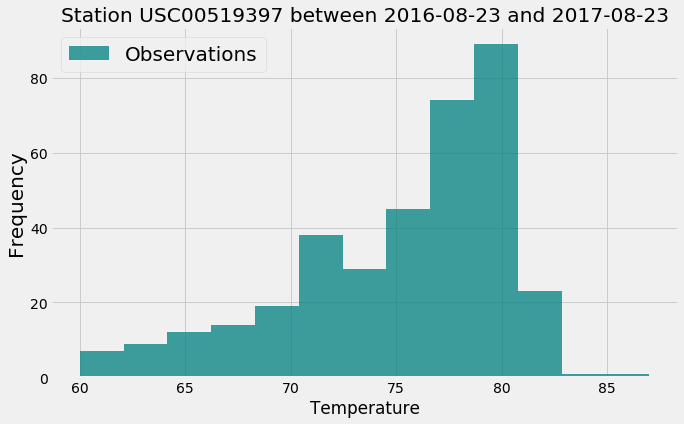

In [250]:
# Choose the station with the highest number of temperature observations.
Most_poppin_station=session.query(Measurement.station,func.count(Measurement.tobs)).\
filter(Measurement.date.between(one_year_date,most_recent_date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
Most_poppin_station = Most_poppin_station[0]
date_range =  'between ' + one_year_date + ' and ' +most_recent_date


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
One_year_Data=pd.DataFrame(session.query(Measurement.station,Measurement.date,Measurement.tobs).\
filter(and_(Measurement.date.between(one_year_date,most_recent_date),
       (Measurement.station == Most_poppin_station))).all())
fig=plt.figure(figsize=(10,6));
n, bins, patches=plt.hist(One_year_Data.tobs,13,facecolor='teal', alpha=0.75);
plt.ylabel("Frequency",fontsize=20);
plt.title(f"Station {Most_poppin_station} {date_range}");
plt.xlabel("Temperature")
plt.legend(['Observations'],loc='best',fontsize=20);

In [256]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [267]:
trip_weather[0][0]

71.0

In [271]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates
trip_weather = (calc_temps('2017-06-23', '2017-06-30'))
print(f"For the trip between dates '2017-06-23', '2017-06-30' \n\
        last years weather was like : \n\
        avg temp is {trip_weather[0][1]}\n\
        min temp is {trip_weather[0][0]}\n\
        max temp is {trip_weather[0][2]}")

For the trip between dates '2017-06-23', '2017-06-30' 
        last years weather was like : 
        avg temp is 77.08
        min temp is 71.0
        max temp is 82.0


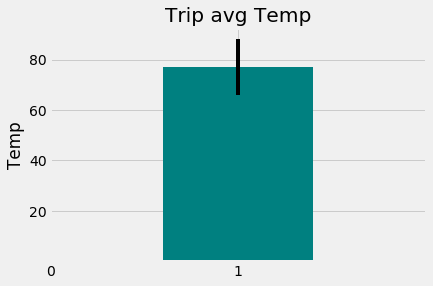

In [278]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, trip_weather[0][1], yerr=trip_weather[0][2]-trip_weather[0][0],color='teal');
plt.xlim((0, 2));
plt.xticks(np.arange(0, 2, step=1));
plt.title("Trip avg Temp")
plt.yticks([20,40,60,80]);
plt.ylabel('Temp');

In [291]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station=session.query(Measurement,Station,func.sum(Measurement.prcp)).\
filter(Measurement.date.between('2017-06-23','2017-06-30')).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

for row in rainfall_per_station:
    print(row[0].station, row[1].name,"Lat:", row[1].latitude, "Lng:",  row[1].longitude,
          "Elevation:" ,row[1].elevation, "Rainfall:", round(row[2],2))

USC00516128 MANOA LYON ARBO 785.2, HI US Lat: 21.3331 Lng: -157.8025 Elevation: 152.4 Rainfall: 1.6
USC00519281 WAIHEE 837.5, HI US Lat: 21.45167 Lng: -157.84888999999998 Elevation: 32.9 Rainfall: 0.58
USC00513117 KANEOHE 838.1, HI US Lat: 21.4234 Lng: -157.8015 Elevation: 14.6 Rainfall: 0.18
USC00519397 WAIKIKI 717.2, HI US Lat: 21.2716 Lng: -157.8168 Elevation: 3.0 Rainfall: 0.14
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US Lat: 21.33556 Lng: -157.71139 Elevation: 19.5 Rainfall: 0.12
USC00517948 PEARL CITY, HI US Lat: 21.3934 Lng: -157.9751 Elevation: 11.9 Rainfall: 0.12
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US Lat: 21.5213 Lng: -157.8374 Elevation: 7.0 Rainfall: 0.0
